<h1>Table od contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preprocessing</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data analysis</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">4&nbsp;&nbsp;</span>Final conclusions</a></span></li></ul></div>

# Data description

In this project, it is necessary to build an ML model that should predict the recovery coefficient of gold from gold-bearing ore using data from extraction and purification parameters. 

The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

**Technological process:**


The extracted ore undergoes primary processing, as a result of which a crushed mixture is obtained. It is sent for flotation (enrichment) and two-stage purification.

1. Flotation

A mixture of gold-bearing ore is fed into the flotation plant. After enrichment, a rough concentrate and "dump tails" are obtained, that is, product residues with a low concentration of valuable metals.
The stability of this process is affected by the unstable and not optimal physico-chemical state of the flotation pulp (a mixture of solid particles and liquid).


2. Cleaning

The rough concentrate undergoes two purifications. At the output, the final concentrate and new dump tails are obtained.

The name of the featuress has the following format:

[stage].[parameter type].[parameter name]

where [stage] can take the following values:

* rougher — flotation
* primary_cleaner — primary cleaning
* secondary_cleaner — secondary cleaning
* final — final characteristics

where [parameter type] can take:

* input — raw material parameters
* output - product parameters
* state — parameters characterizing the current state of the stage
* calculation — calculated characteristics

where [parameter name] can form or to describe the technological process

* rougher feed — feedstock
* rougher additions (or reagent additions) — flotation reagents
* Xanthate — xanthogenate (promoter, or flotation activator)
* Sulfate — sulfate (sodium sulfide in this production)
* Depressant — depressant (sodium silicate)
* Rougher process (rough process) — flotation
* Rougher tails — dump tails
* Float banks — flotation plant
* Cleaner process — cleaning
* Rougher Au — rough gold concentrate
* Final Au — final gold concentrate

or to describe the parameters of the stage:

* air amount — air volume
* fluid levels — liquid level
* feed size — the size of the raw material granules
* feed rate — feed rate

Predicted values:

* rougher.output.recovery - efficiency of rough concentrate enrichment
* final.output.recovery - final concentrate enrichment efficiency

## 1.  Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats as st
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import math
import warnings

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, make_scorer

In [2]:
# Disabling Anaconda warnings
warnings.simplefilter('ignore')

# Setting the maximum number of columns in the dateframe to be displayed
pd.set_option('display.max_columns',None)

In [3]:
df_train = pd.read_csv('gold_recovery_train_new.csv', index_col='date', parse_dates=True)
df_test = pd.read_csv('gold_recovery_test_new.csv', index_col='date', parse_dates=True)
df_full = pd.read_csv('gold_recovery_full_new.csv', index_col='date', parse_dates=True)

In [4]:
datasets = {'df_train':df_train,'df_test':df_test,'df_full':df_full}

In [5]:
# Let's write a function to describe our dataframes
def explore_data(name, data):
    print('General information about the dataframe {}'.format(name))
    print()
    display(data.info())
    print(f'Dataframe {name} has {data.duplicated().sum()} duplicates which constitute - {data.duplicated().sum().mean()}%.')
    print()
    print(f"Let's look at the first 5 lines of the dataframe {name}")
    print()
    display(data.head())
    print()
    print(f'The last 5 lines of {name} dataframe.')
    print()
    display(data.tail())
    print()
    print(f'Randomly selected lines of {name} dataframe')
    print()
    display(data.sample(5))
    print()
    print('--------------------------------------------------------------------------------')
    print('********************************************************************************')
    print('--------------------------------------------------------------------------------')
    print()
    return

In [6]:
# We automate the initial data analysis of each dataframe
for key, value in datasets.items():
    explore_data(key,value)

General information about the dataframe df_train

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  floa

None

Dataframe df_train has 0 duplicates which constitute - 0.0%.

Let's look at the first 5 lines of the dataframe df_train



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.


The last 5 lines of df_train dataframe.



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,8.028927,6.5,1.304232,6.559174,12.445966,7.056338,32.940215,22.854592,6.531541,3.934320,2.314352,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,-399.363624,1648.833984,-399.669220,45912.942619,2497.652954,2499.177950,1.155559,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,7.762770,9.158609,7.766744,9.156069,11.124896,10.984003,30.068876,18.603550,89.574376,4.207261,0.612935,16.666590,0.748633,1199.245914,-300.845518,1149.807890,-498.789721,1047.963596,-498.413079,946.640977,-499.152477,849.664935,-499.214461,849.758091,-497.448664,0.0,0.0,0.0,0.0,35.043205,-499.045671,29.906659,-499.979939,26.002402,-499.953431,22.987238,-499.967351,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470


Randomly selected lines of df_train dataframe



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-19 17:59:59,5.776113,10.632447,9.725981,44.621481,59.516150,8.671254,2.704904,12.486281,3.334305,132.284130,6.012466,7.46,0.794050,9.114413,10.401121,8.966681,31.403210,13.914147,2.117996,8.029762,2.998227,1701.237794,-499.456045,1701.477700,-500.290244,1699.482029,-497.075455,1700.535617,-500.223893,43985.470332,3224.413968,3224.900322,1.988383,8.627351,3.732139,533.086874,59.659062,43.750699,7.420922,12.498849,5.410102,12.498846,5.409215,11.928278,8.254430,27.070014,18.944299,79.032970,7.256492,0.940216,23.021311,2.253658,1299.642607,-299.645519,1499.936962,-500.092717,1499.622925,-499.684049,1393.421242,-500.072735,1199.822781,-500.528561,1199.875410,-500.082122,12.402776,3.353394,9.803607,3.624296,34.905838,-499.792154,30.096438,-500.191564,36.994128,-399.929755,19.979607,-500.056415,25.033370,-397.895155,23.033514,-399.822556,25.512989,-446.986489,19.907194,-449.613233,24.978721,-497.033717
2017-01-10 06:59:59,4.291679,7.678790,13.588372,45.605069,72.648230,9


--------------------------------------------------------------------------------
********************************************************************************
--------------------------------------------------------------------------------

General information about the dataframe df_test

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    529

None

Dataframe df_test has 0 duplicates which constitute - 0.0%.

Let's look at the first 5 lines of the dataframe df_test



,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289


The last 5 lines of df_test dataframe.



,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-31 19:59:59,173.957757,15.963399,8.07,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,-499.599127,1400.334792,-499.243459,11.638973,4.695306,521.685155,66.758479,42.022027,10.554544,10.109194,7.203935,10.110793,7.198171,1399.935264,-299.999637,1049.641991,-500.074887,951.923857,-499.648793,852.337438,-498.464443,851.436769,-500.285584,851.461345,-499.735650,21.912132,-499.915179,19.909080,-499.734909,24.939573,-500.098479,12.968448,-499.952023,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
2017-12-31 20:59:59,172.910270,16.002605,8.07,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,-503.587739,1447.653388,-480.403849,11.338091,4.478381,530.195798,62.560684,41.096377,10.254051,9.979495,7.200895,9.978855,7.201957,1406.122319,-299.057200,1055.715243,-498.250207,956.850266,-497.403941,855.386714,-495.702676,852.071335,-499.442753,851.328986,-496.579809,25.322301,-497.034975,23.310568,-498.892647,26.369171,-499.222375,17.704862,-499.545681,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
2017-12-31 21:59:59,171.135718,15.993669,8.07,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,-520.667442,1502.585343,-498.260225,11.285908,4.405327,546.306868,73.647513,41.095485,10.169094,10.182219,7.196255,10.185461,7.198676,1396.203070,-300.210722,1047.879742,-499.604248,948.963429,-499.549567,856.325597,-500.095616,850.614597,-499.473713,850.279578,-498.508374,29.075948,-500.528402,26.888005,-500.975799,28.000224,-500.565876,22.996528,-500.477583,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
2017-12-31 22:59:59,179.697158,15.438979,8.07,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,-487.479567,1502.688918,-501.569723,11.289710,4.343488,547.331405,78.066446,41.715740,10.071156,10.730915,7.200058,10.726349,7.200834,1403.942288,-300.030119,1049.802289,-499.795576,950.769390,-500.37464


Randomly selected lines of df_test dataframe



,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-10-12 05:59:59,179.476228,5.974416,6.88,2.404080,1395.372946,-500.243265,1402.061236,-494.877552,1401.140970,-505.368474,1400.032490,-499.511718,5.579628,3.614914,644.682039,66.161451,44.366608,6.932662,17.998026,6.398844,18.000434,6.401185,1003.016741,-299.988270,1102.482486,-499.312710,1052.188577,-499.540137,1006.476299,-500.449242,899.212200,-499.476893,899.248013,-499.226023,26.901634,-499.876124,23.957482,-499.577190,22.028960,-500.476355,19.946414,-500.212236,18.024864,-500.474529,16.068741,-399.948792,12.972526,-499.759823,10.006670,-499.785950,13.972957,-500.630766
2017-10-25 03:59:59,212.663026,11.961622,6.37,2.827371,1700.396587,-498.700533,1700.628292,-499.766582,1630.031498,-499.533253,1700.939124,-499.778669,12.508101,3.839338,590.608898,55.806486,41.024673,10.970207,17.796183,7.598056,17.786667,7.599041,1300.616165,-300.137925,1000.278739,-500.196108,951.253991,-500.502906,899.120002,-500.606619,850.370062,-499.876880,850.256436,-501.995372,5.824429,-775.871025,4.947742,-794.816987,24.987740,-500.404979,22.997838,-501.158511,20.991109,-501.013774,19.120560,-399.916014,15.012409,-501.449826,10.963141,-500.008335,16.012520,-500.473820
2016-12-17 05:59:59,198.155422,9.985813,7.42,1.447516,1498.077899,-500.389182,1497.959358,-500.332854,1496.463431,-500.478114,1499.463006,-499.648623,10.602113,4.217026,376.892102,42.451349,32.148086,10.287603,13.999392,5.799028,13.999466,5.800174,1000.312593,-499.950323,1400.531156,-500.075314,1400.969287,-499.381482,1409.109495,-499.031314,1049.916673,-500.295138,949.879464,-498.883565,27.089771,-500.325076,23.093394,-500.110240,29.995192,-500.468806,27.021115,-500.351838,17.024414,-499.950174,14.900632,-500.995570,17.838051,-499.550084,11.998869,-499.660774,20.991575,-499.985799
2017-09-12 15:59:59,185.146199,6.973429,6.82,0.994758,1300.342348,-500.744426,1295.977304,-500.385396,1301.752355,-500.606501,1298.022367,-500.473867,6.479322,3.060697,493.279533,58.554944,38.349566,7.447738,17.001164,5.599315,17.002272,5.597135,1006.249618,-299.999147,1305.139855,-500.763550,1253.267660,-49


--------------------------------------------------------------------------------
********************************************************************************
--------------------------------------------------------------------------------

General information about the dataframe df_full

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  flo

None

Dataframe df_full has 0 duplicates which constitute - 0.0%.

Let's look at the first 5 lines of the dataframe df_full



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.


The last 5 lines of df_full dataframe.



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,8.028927,6.5,1.304232,6.559174,12.445966,7.056338,32.940215,22.854592,6.531541,3.934320,2.314352,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,-399.363624,1648.833984,-399.669220,45912.942619,2497.652954,2499.177950,1.155559,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,7.762770,9.158609,7.766744,9.156069,11.124896,10.984003,30.068876,18.603550,89.574376,4.207261,0.612935,16.666590,0.748633,1199.245914,-300.845518,1149.807890,-498.789721,1047.963596,-498.413079,946.640977,-499.152477,849.664935,-499.214461,849.758091,-497.448664,0.0,0.0,0.0,0.0,35.043205,-499.045671,29.906659,-499.979939,26.002402,-499.953431,22.987238,-499.967351,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470


Randomly selected lines of df_full dataframe



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-12-18 08:59:59,4.634713,11.752721,12.966384,43.413629,74.544326,10.523398,3.948947,6.739875,2.982287,201.925624,12.040279,7.400,0.997505,7.737475,12.842600,10.970985,34.017952,17.519732,4.216527,8.196541,2.716131,1499.844185,-500.091934,1500.532277,-499.102173,1503.274291,-496.719518,1500.758324,-501.185414,59978.330638,3948.039449,3948.231692,1.995992,8.788600,4.886561,380.121541,42.243873,30.684749,9.753533,15.001323,6.053058,14.995742,6.048496,12.670779,9.746506,34.308594,22.268819,89.015365,6.098911,0.401321,13.270690,1.756029,995.539124,-499.846654,1398.652676,-499.776551,1398.309135,-499.579667,1398.821335,-499.770557,1049.740704,-499.888770,948.769368,-498.645300,15.434195,5.566569,10.374630,1.954630,27.139085,-499.887424,23.126515,-500.157979,30.003038,-500.162174,27.028422,-499.882238,17.033132,-500.279941,15.040851,-499.469780,17.482401,-500.142437,11.997159,-499.951902,21.014736,-499.509949
2016-10-20 08:59:59,6.159709,9.617999,10.636974,45.470497,67.69146


--------------------------------------------------------------------------------
********************************************************************************
--------------------------------------------------------------------------------



<div style="font-size: 20px">
    

**Calculating the enrichment efficiency**

Recovery = (C * (F - T)) / (F * (C - T)) * 100%

* C — the proportion of gold in the concentrate after flotation/purification;


* F — the proportion of gold in the raw material/concentrate before flotation/purification;


* T - the proportion of gold in the tailings after flotation/purification.

In [7]:
c = df_train['rougher.output.concentrate_au']
f = df_train['rougher.input.feed_au']
t = df_train['rougher.output.tail_au']

df_train['rougher.output.recovery_calculated'] = ((c*(f - t))/(f * (c - t))) * 100

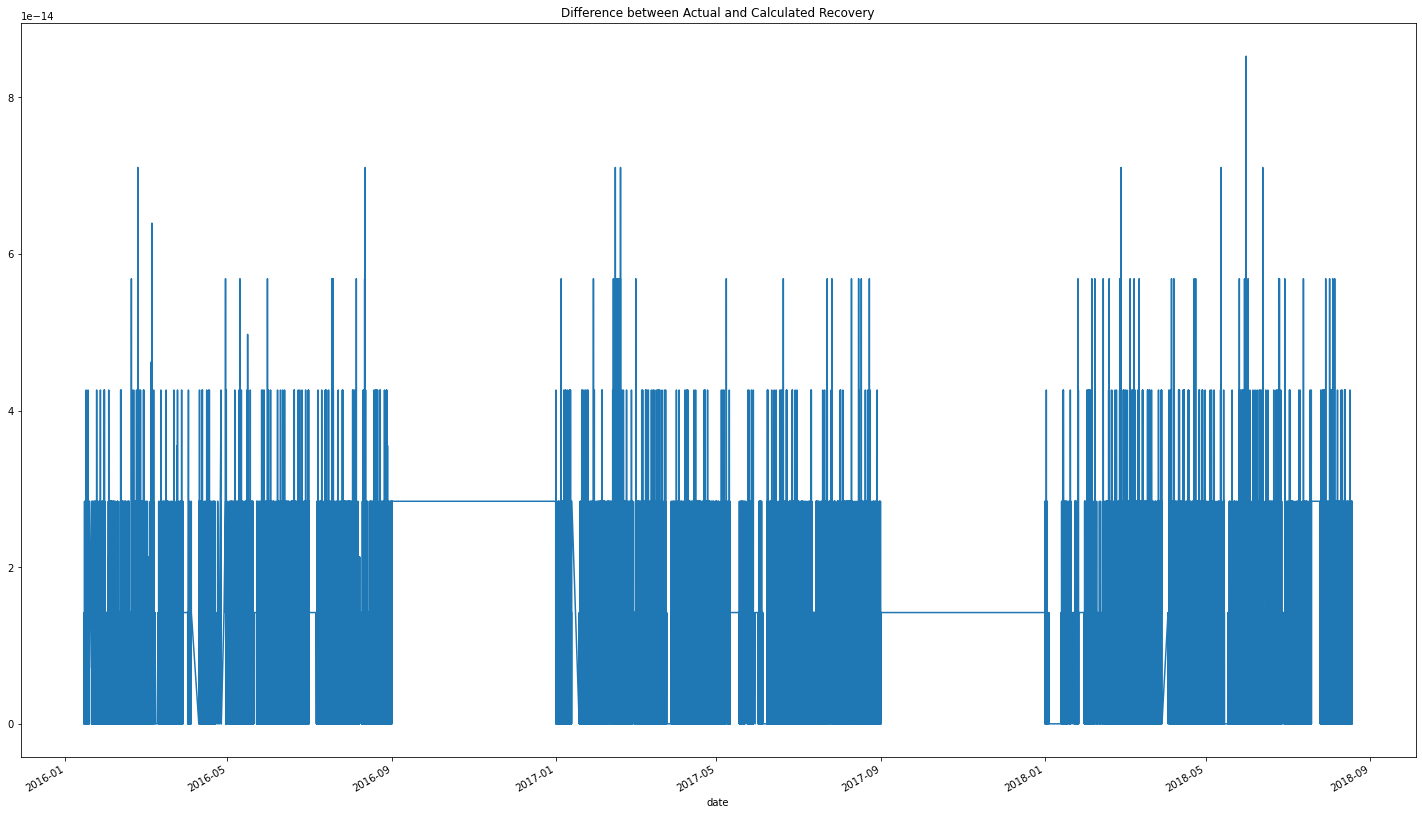

MAE: 9.73512347450521e-15


In [8]:
difference = abs(df_train['rougher.output.recovery'] - df_train['rougher.output.recovery_calculated'])

difference.plot(figsize=(25,15))
plt.title('Difference between Actual and Calculated Recovery')
plt.show()
print('MAE:',difference.mean())

Let's estimate the proportion of rows with omissions in the training sample.

In [9]:
сrude_clean = df_train.dropna().shape[0]
crude_clean_p = (df_train.shape[0] - сrude_clean) / df_train.shape[0]
print(f'In the training sample {сrude_clean} rows can be potentially deleted which constitutes {crude_clean_p:.2%}')

In the training sample 11017 rows can be potentially deleted which constitutes 22.14%


Since the proportion of rows with missing values is large, they need to be filled in additionally. Since the data in the training sample is structured by dates, we will fill in the missing values with the previous non-zero.

In [10]:
# Filling in missing values with previous values
df_train.fillna(method='ffill', inplace=True)
df_test.fillna(method='ffill', inplace=True)
df_full.fillna(method='ffill', inplace=True)

Let's check if the MAE metric has deteriorated:

In [11]:
print(mean_absolute_error(df_train['rougher.output.recovery'], df_train['rougher.output.recovery_calculated']))

9.73512347450521e-15


<div style="font-size: 20px">
    

**Determination of missing features in the test sample (relative to the training one)**

In [12]:
set(list(df_train.columns.values))-set(list(df_test.columns.values))

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.recovery_calculated',
 'rougher.output.tail_ag',
 'rough

<div style="font-size: 20px">
    

**Intermediate conclusion:**

1) three dataframes are presented for analysis: initial data, training and test samples. The dataframe of the initial data has 19439 rows and 86 columns. Since there were a significant number of missing values in the training sample data, it was decided to fill in the missing values with the values of the previous row due to the structuring of data by dates;


2) the final value of the MAE metric has not changed in comparison with that before filling in the missing values, which suggests that the filled cells should not negatively affect further research;


3) there are no signs of the final stage in the test sample, as well as the parameters of flotation or purification at the output, as well as some design parameters that cannot be obtained or measured during the technological process.

So, in the future, to train the ML model, we will use only those features that are present in the test sample in the training sample.

## 2.  Data analysis

<div style="font-size: 20px">
    

**Analysis of changes in the concentration of metals at various stages of purification**

Since the date column is not useful to us for further research, we will delete it.

In [13]:
df_train.reset_index(drop=False, inplace=True)
df_test.reset_index(drop=False, inplace=True)
df_full.reset_index(drop=False, inplace=True)

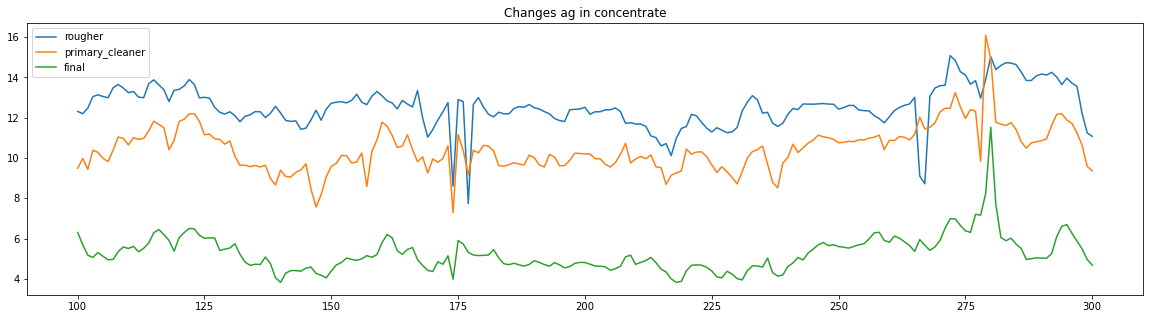

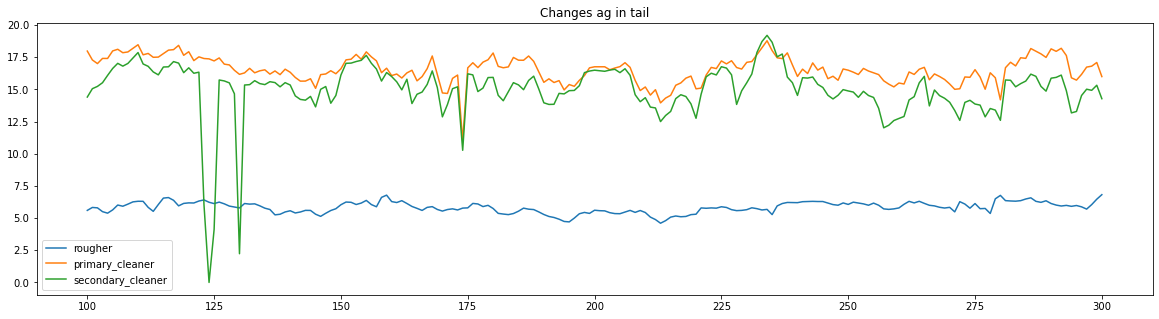

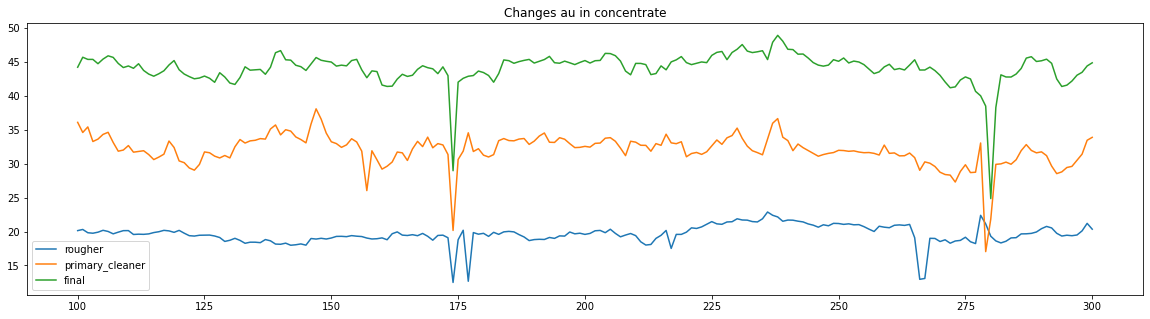

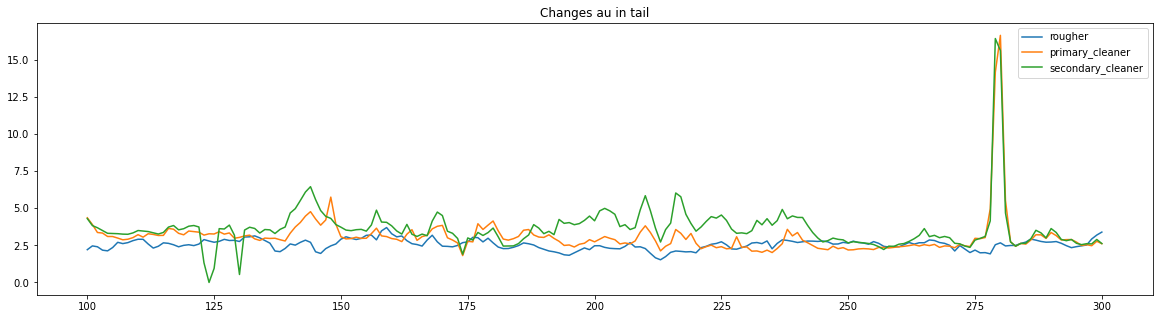

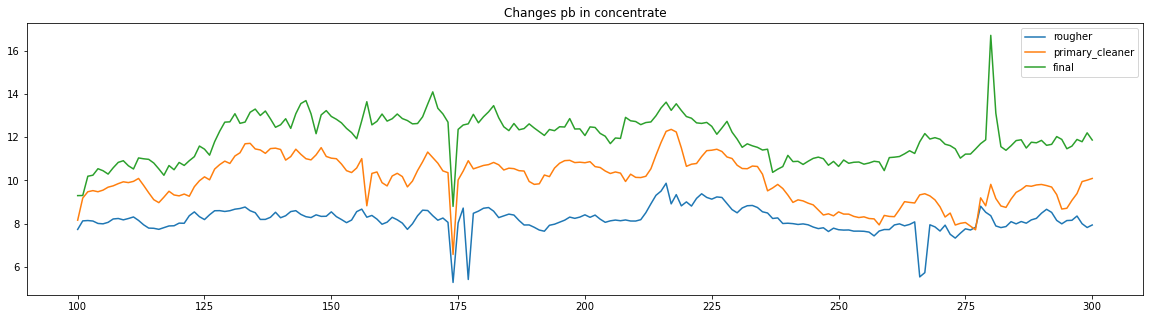

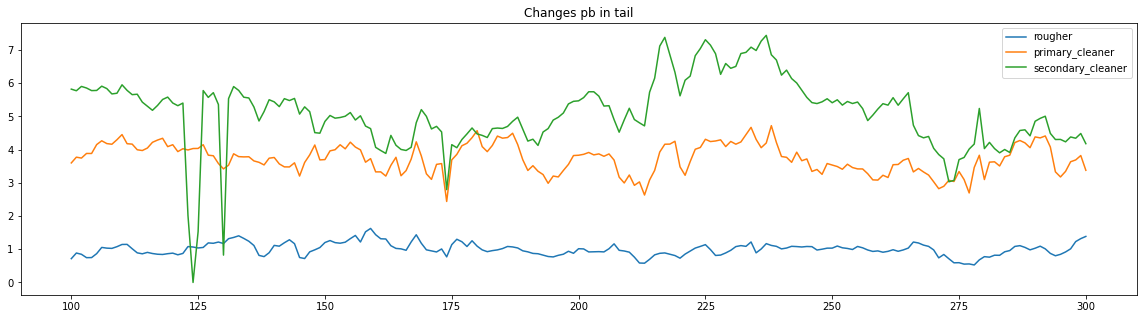

In [14]:
stages = ['rougher', 'primary_cleaner', 'secondary_cleaner']
metals = ['ag','au','pb']
parts = ['concentrate','tail']

for metal in metals:
    for part in parts:
        plt.figure(figsize=(20,5))
        for i, stage in enumerate(stages):
            if i==2 and part=='concentrate':
                stage='final'
            column_name=f'{stage}.output.{part}_{metal}'
            df_full.loc[100:300, column_name].plot(label=stage)
            plt.title(f'Changes {metal} in {part}')
            plt.legend()
        plt.show()

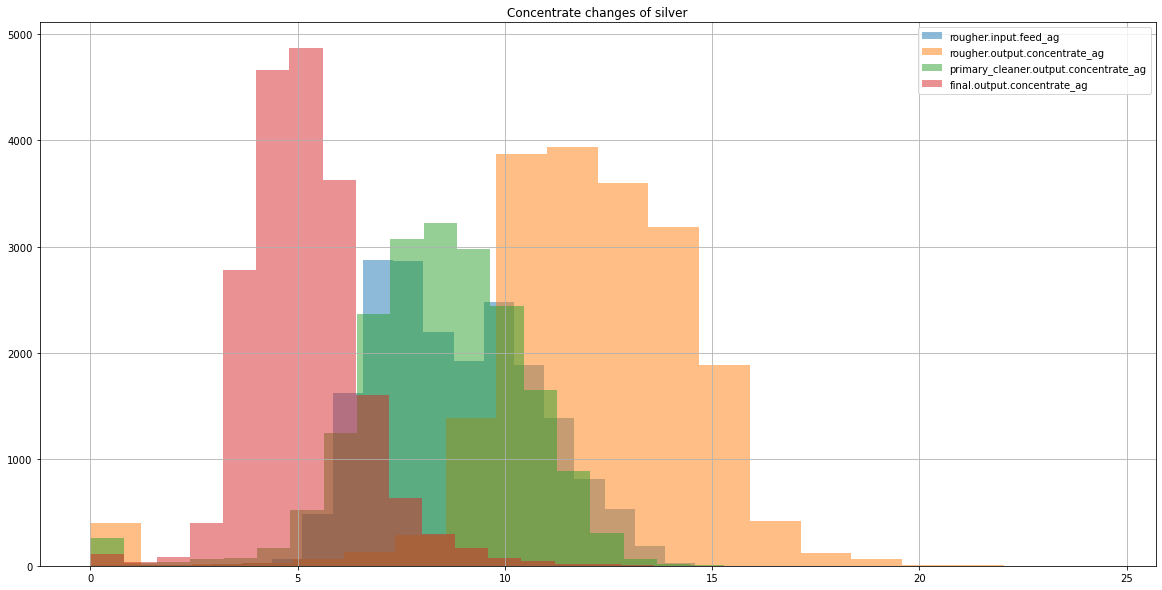

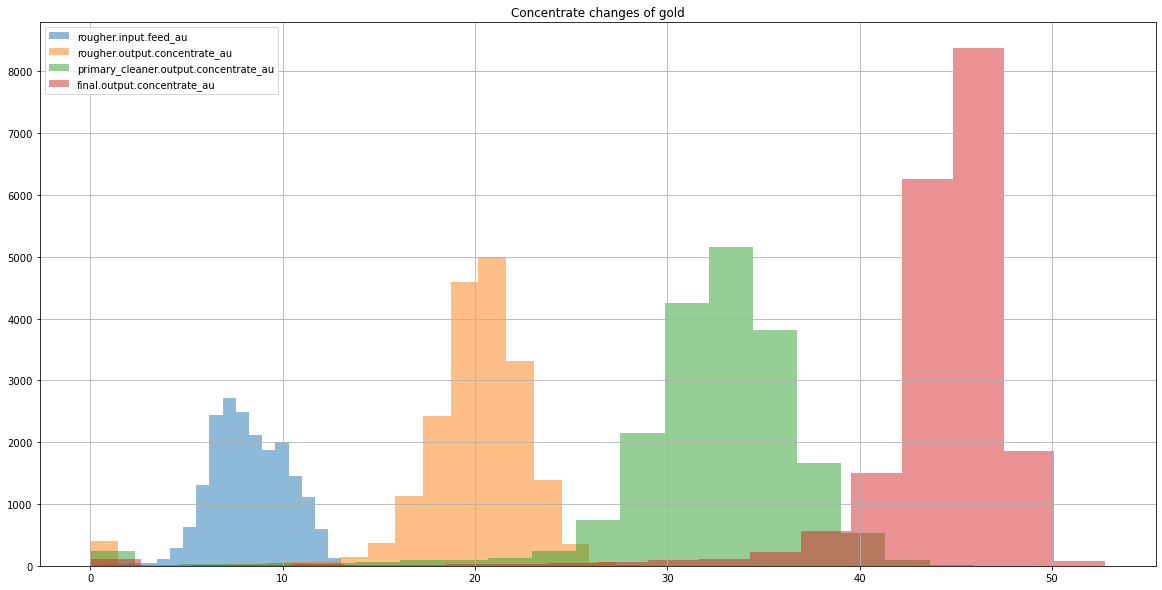

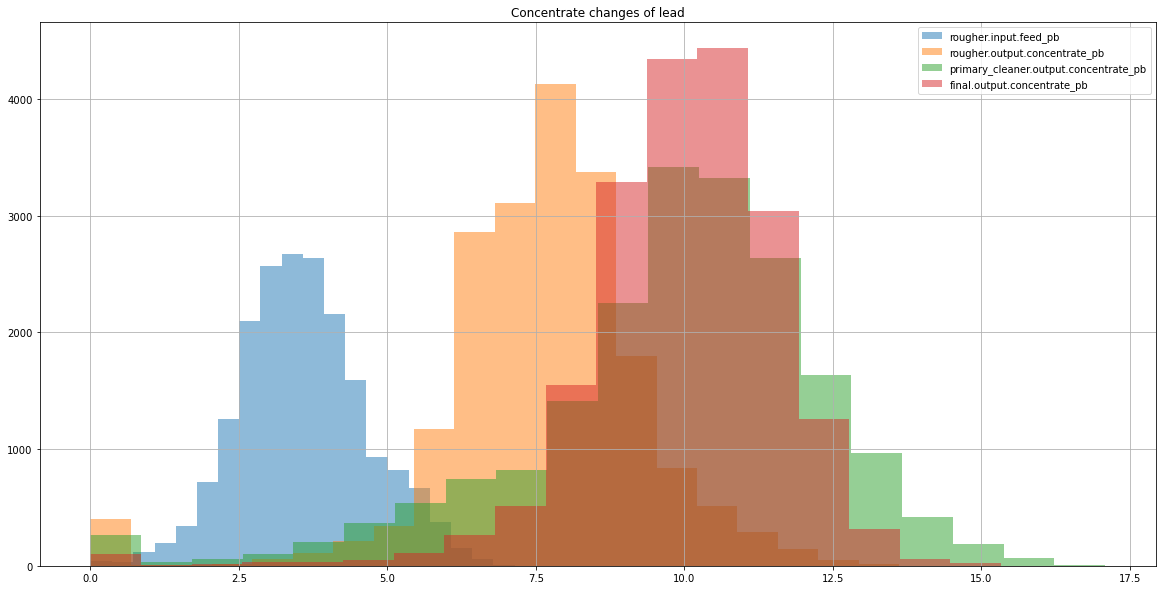

In [15]:
steps_template = [
    'rougher.input.feed_{}',
    'rougher.output.concentrate_{}',
    'primary_cleaner.output.concentrate_{}',
    'final.output.concentrate_{}',
]

metals = {'ag':'silver','au':'gold','pb':'lead'}

def plot_concentrate_progress(component):
    steps = [s.format(component) for s in steps_template]
    plt.figure(figsize=(20,10))
    for step in steps:
        df_full[step].hist(alpha=0.5, bins=20)
    plt.legend(steps)
    
    
for key, value in metals.items():
    
    plot_concentrate_progress(key)
    plt.title(f'Concentrate changes of {value}')
    plt.show()

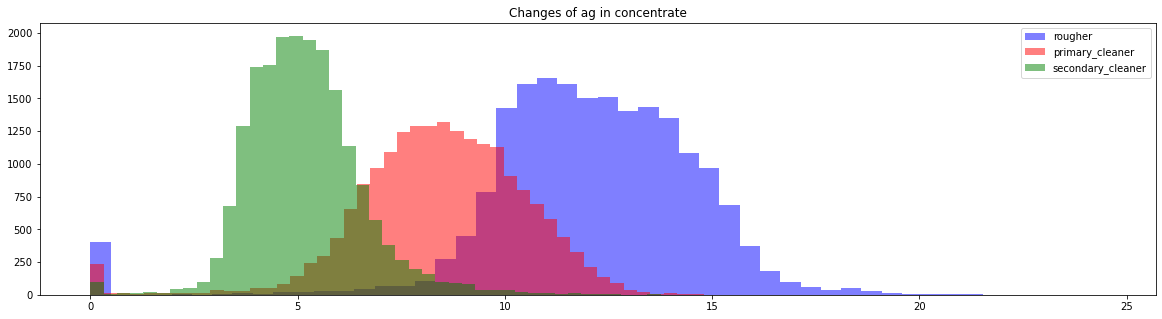

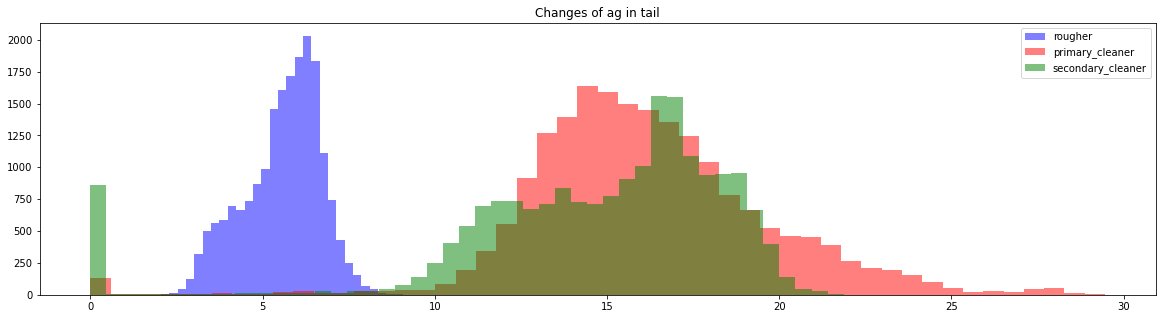

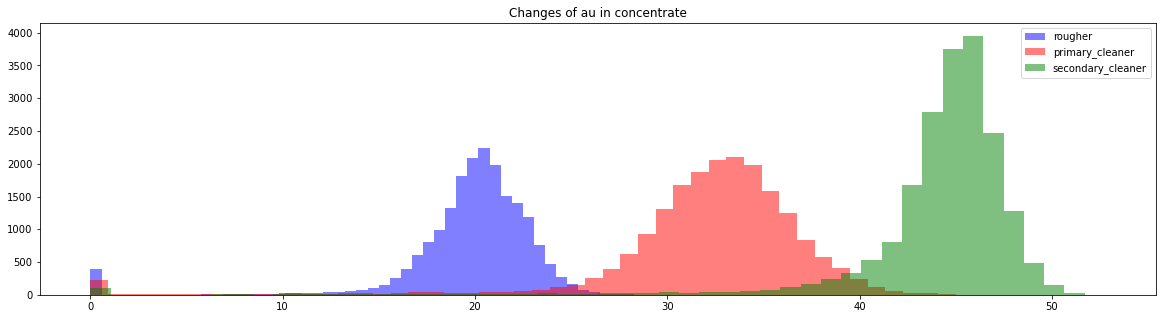

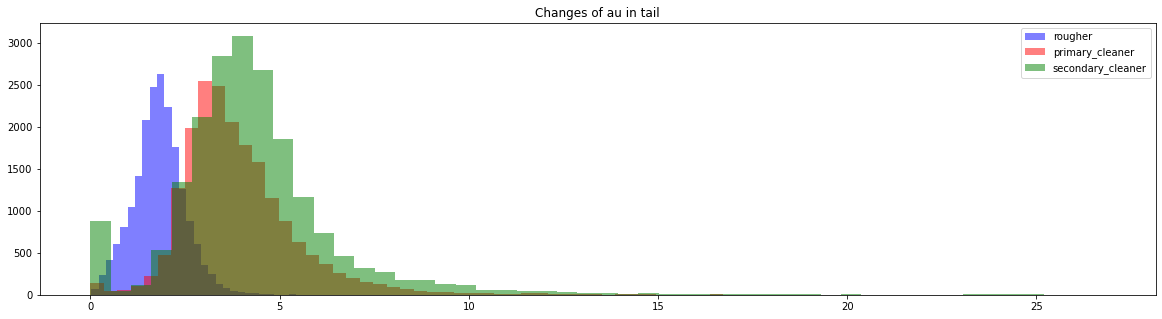

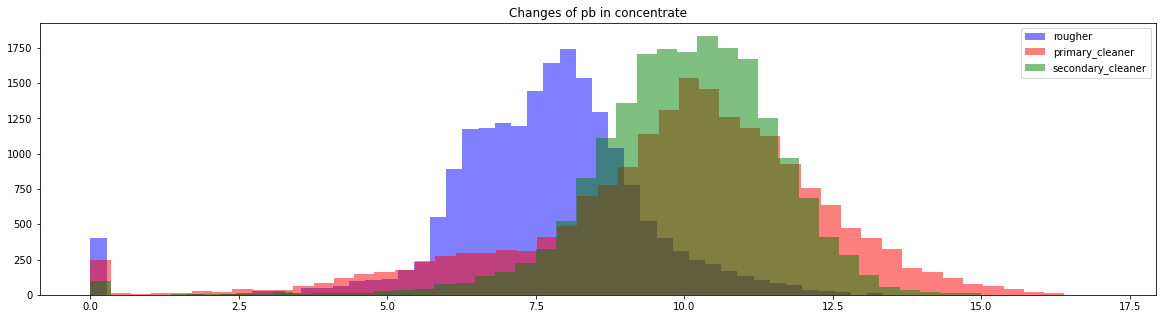

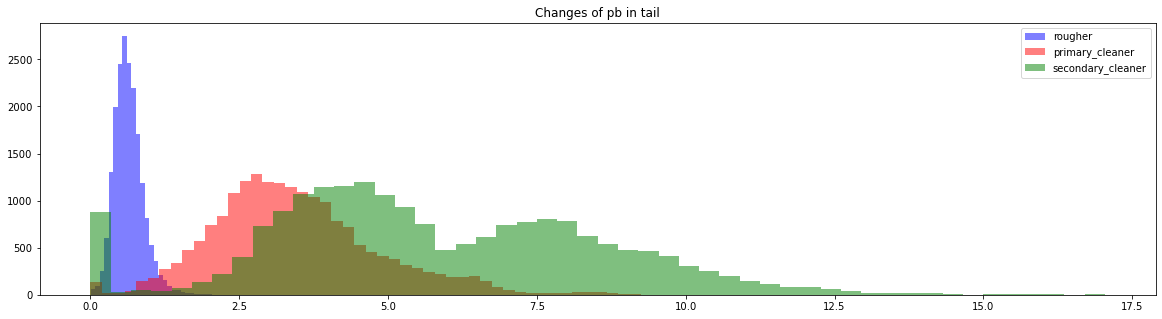

In [16]:
stages = ['rougher', 'primary_cleaner', 'secondary_cleaner']
metals = ['ag','au','pb']
parts = ['concentrate','tail']
        
for metal in metals:
    for part in parts:
        column_names=[]
        plt.figure(figsize=(20,5))
        for i, stage in enumerate(stages):
            if i == 2 and part == 'concentrate':
                stage='final'
            column_name=f'{stage}.output.{part}_{metal}'
            column_names.append(column_name)
        plt.hist(df_full[column_names[0]],bins=50, label=stages[0], fill=True, alpha=0.5, color='blue')
        plt.hist(df_full[column_names[1]],bins=50, label=stages[1], fill=True, alpha=0.5, color='red')
        plt.hist(df_full[column_names[2]],bins=50, label=stages[2], fill=True, alpha=0.5, color='green')
        plt.title(f'Changes of {metal} in {part}')
        plt.legend()
        plt.show()

<div style="font-size: 20px">
    

**Comparison of the distribution of raw material granule sizes on training and test samples**

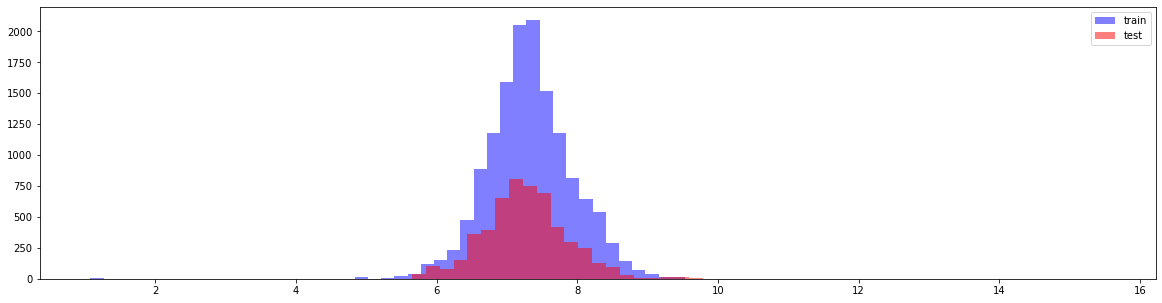

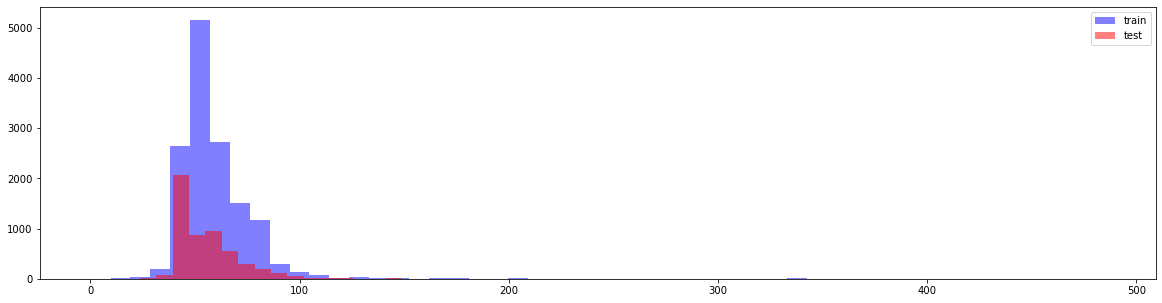

In [17]:
stages = ['primary_cleaner.input.feed_size','rougher.input.feed_size']
dfs = [df_train, df_test]

for stage in stages:
    plt.figure(figsize=(20,5))
    plt.hist(dfs[0][stage],bins=50, label='train', fill=True, alpha=0.5, color='blue')
    plt.hist(dfs[1][stage], bins=50, label='test', fill=True, alpha=0.5, color='red')
    plt.legend()
    plt.show()

<div style="font-size: 20px">
    

**The total concentration of all substances at various stages**

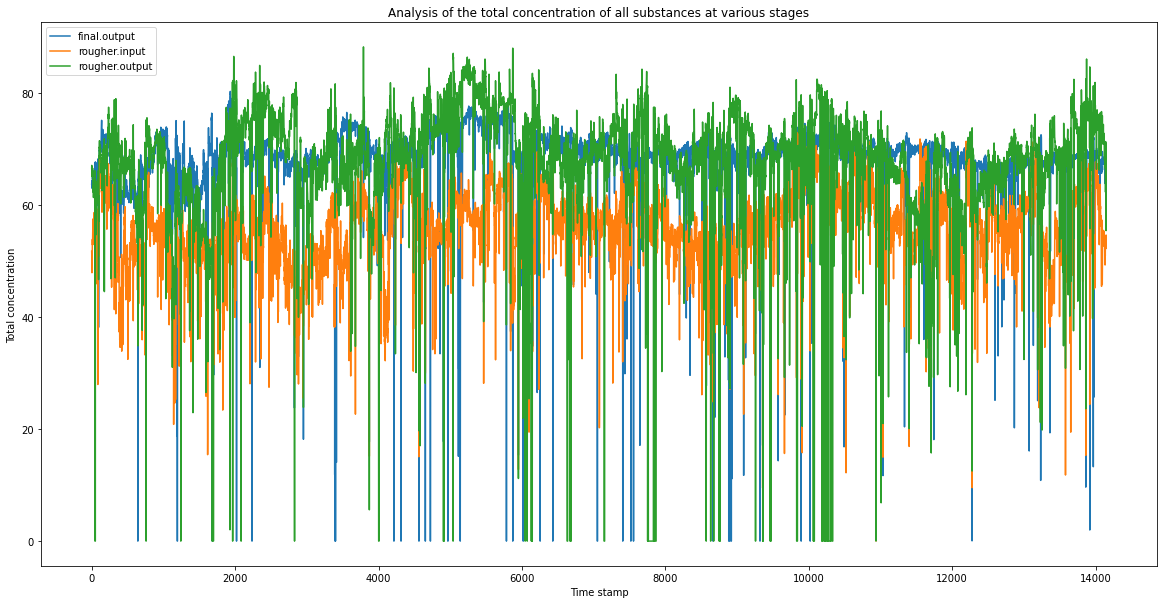

In [18]:
stages = ['final.output', 'rougher.input', 'rougher.output']
params = ['concentrate_', 'feed_', 'concentrate_']
metals = ['ag', 'pb', 'au','sol']

df_for_parse = pd.DataFrame(columns=stages)

for stage in zip(stages,params):
    sum_concentrate = df_train[f'{stage[0]}.{stage[1]}{metals[0]}'].copy()
    for metal in metals[1:]:
        sum_concentrate += df_train[f'{stage[0]}.{stage[1]}{metal}']
    df_for_parse[stage[0]]=sum_concentrate
    
df_for_parse.plot(figsize=(20,10))
plt.legend()
plt.title('Analysis of the total concentration of all substances at various stages')
plt.ylabel('Total concentration')
plt.xlabel('Time stamp')
plt.show()

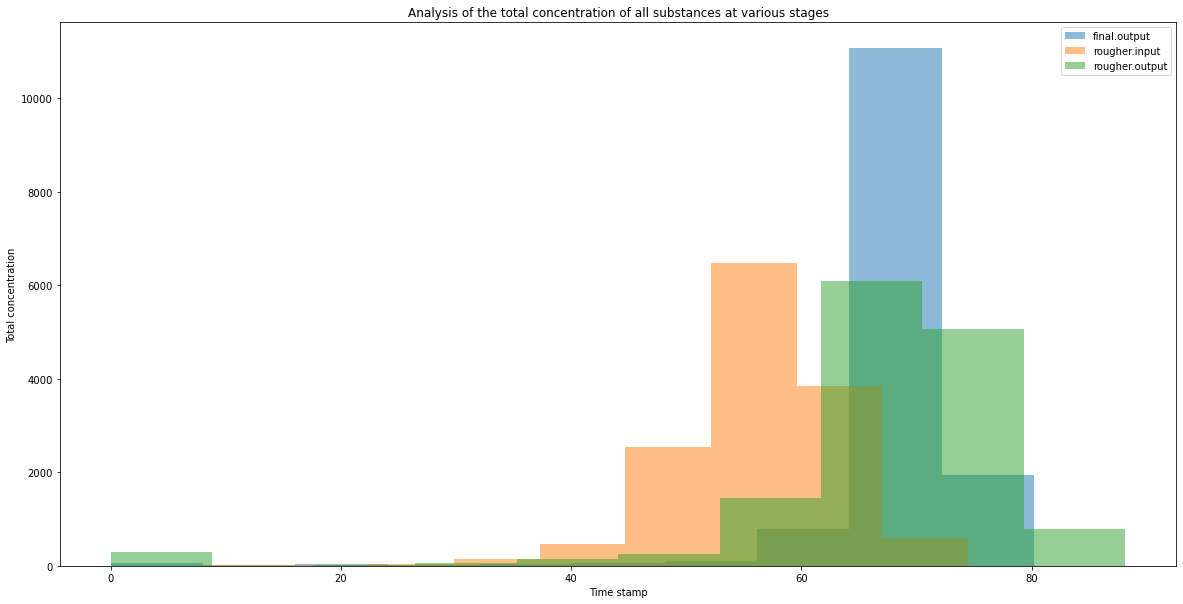

In [19]:
stages = ['final.output', 'rougher.input', 'rougher.output']
metals = ['ag','au','pb', 'sol']
params = ['concentrate_','feed_', 'concentrate_']
df_for_parse = pd.DataFrame(columns=stages)

for stage in zip(stages,params):
    sum_concentrate = df_train[f'{stage[0]}.{stage[1]}{metals[0]}'].copy()
    for metal in metals[1:]:
        sum_concentrate += df_train[f'{stage[0]}.{stage[1]}{metal}']
    df_for_parse[stage[0]]=sum_concentrate

plt.figure(figsize=(20,10))
plt.hist(df_for_parse[stages[0]],label=stages[0], fill=True, alpha=0.5)
plt.hist(df_for_parse[stages[1]],label=stages[1],fill=True, alpha=0.5)
plt.hist(df_for_parse[stages[2]],label=stages[2],fill=True, alpha=0.5)
plt.legend()
plt.title('Analysis of the total concentration of all substances at various stages')
plt.ylabel('Total concentration')
plt.xlabel('Time stamp')
plt.show()

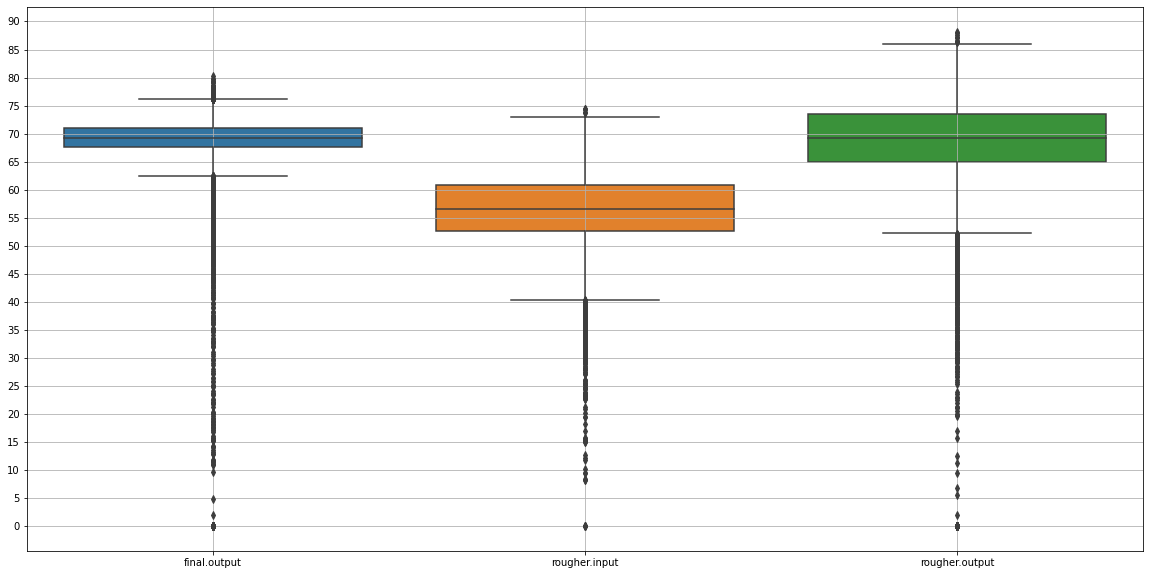

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=df_for_parse, ax=ax)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.grid()
plt.show()

In [21]:
# Let's calculate the total concentration on rougher.input in the training sample
df_train['sum_concentrate'] = (df_train['rougher.input.feed_ag'] +
                                 df_train['rougher.input.feed_pb'] +
                                 df_train['rougher.input.feed_sol'] +
                                 df_train['rougher.input.feed_au'])

In [22]:
# Let's calculate the total concentration on the rougher.input in the test sample
df_test['sum_concentrate'] = (df_test['rougher.input.feed_ag'] +
                                 df_test['rougher.input.feed_pb'] +
                                 df_test['rougher.input.feed_sol'] +
                                 df_test['rougher.input.feed_au'])

In [23]:
df_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_calculated,sum_concentrate
count,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,1.414900e+04,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.

In [24]:
upper_outler = df_train['sum_concentrate'].mean() + 3 * df_train['sum_concentrate'].std()
lower_outler = df_train['sum_concentrate'].mean() - 3 * df_train['sum_concentrate'].std()

In [25]:
# Let's delete all missing values (above and below 3 sigma)
df_train = df_train[(df_train['sum_concentrate'] < upper_outler) & 
                        (df_train['sum_concentrate'] > lower_outler)]
df_test = df_test[(df_test['sum_concentrate'] < upper_outler) &
                      (df_test['sum_concentrate'] > lower_outler)]

In [26]:
# Discard all values with zero values of the target features
df_train = df_train[(df_train['rougher.output.recovery'] > 0) &
                        (df_train['final.output.recovery'] > 0)]

In [27]:
df_full.set_index('date', inplace=True)
df_test.set_index('date', inplace=True)
df_train.set_index('date', inplace=True)

In [28]:
test_target = df_full.loc[df_test.index][['rougher.output.recovery',
                                         'final.output.recovery']]

In [29]:
# MAE between calculations and the value of the attribute after eliminating all outliers
mean_absolute_error(df_train['rougher.output.recovery'],
                    df_train['rougher.output.recovery_calculated'])

9.959319130226888e-15

<div style="font-size: 20px">
    

**Intermediate conclusion:**

1) Most of the silver goes into the tailings at the flotation stage, and at the purification stages the concentration of silver changes slightly. As the pulp progresses through the purification stages, the proportion of silver in the concentrate gradually decreases from one stage to another, and in the tailings, on the contrary, increases.  The proportion of lead and gold in the concentrate increases with the enrichment and purification of raw materials. The concentration of gold in the tailings varies to a lesser extent than the concentration of other metals.

2) The size distributions of raw material granules on the training and test samples have almost the same appearance, which indicates that the simulated process is stationary in time and the data for the test and training samples are taken from the same general population. The difference in bell heights is due to the size of the samples

3) When analyzing the concentrations of substances at various stages, anomalies were detected, which we get rid of using boxplot, on the basis of which we determine the boundary values in the range of 3 sigma (99.7% of all data). We throw out only those values that go beyond the specified ranges only in the rougher.input column, since the other 2 columns are not inputs of the machine learning model and their elimination will lead to the loss of significant information.

## 3.  Model

The enrichment efficiency is calculated by the formula:

$$ sMAPE = \frac{1}{N} \sum\limits_{i=1}^n \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|) / 2} * 100\% $$

In [30]:
def smape(actual,predicted):
    
    actual = np.array(actual)
    predicted=np.array(predicted)
    
    numerator = np.abs(actual - predicted) * 2
    denominator = np.abs(actual) + np.abs(predicted)
    
    return (numerator/denominator).mean() * 100

Final metric:

$$sMAPE_{итоговая} = 0.25 * sMAPE_{rougher} + 0.75 * sMAPE_{final}$$

In [31]:
def final_smape(actual, predicted):
    actual=np.array(actual)
    predicted=np.array(predicted)
    return (0.25*smape(actual[:,0],predicted[:,0])+
            0.75*smape(actual[:,1], predicted[:,1]))

In [32]:
# Predicted values from the training sample
train_target = df_train[['rougher.output.recovery',
                        'final.output.recovery']]

<div style="font-size: 20px">
    

**Static model with median prediction**

In [33]:
train_median = pd.DataFrame(index=train_target.index)
train_median['rougher.output.recovery'] = df_train['rougher.output.recovery'].median()
train_median['final.output.recovery'] = df_train['final.output.recovery'].median()
final_smape(train_target, train_median)

9.200863777888873

<div style="font-size: 20px">
    

**Static model with average prediction**

In [34]:
train_mean = pd.DataFrame(index=train_target.index)
train_mean['rougher.output.recovery'] = df_train['rougher.output.recovery'].mean()
train_mean['final.output.recovery'] = df_train['final.output.recovery'].mean()
final_smape(train_target, train_mean)

9.235271631001824

<div style="font-size: 20px">
    

**Static model with prediction based on previous values**

In [35]:
# One day - 24 previous entries
train_actual = train_target[24:].reset_index(drop=True)
train_predicted = train_target[:-24].reset_index(drop=True)
final_smape(train_actual, train_predicted)

9.66015017372853

<div style="font-size: 20px">
    

**Training models using cross-validation**

In [36]:
# selection of features and targets
x = df_train[df_test.columns]
y = df_train[['rougher.output.recovery', 'final.output.recovery']]


In [37]:
# Let's normalize x
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [38]:
final_smape_scorer = make_scorer(final_smape, greater_is_better=False)

We will train linear regression, decision tree and random forest models and evaluate the quality using cross-validation

In [39]:
# Linear regression
model = LinearRegression()
print('Linear regression:', abs(cross_val_score(model, x, np.array(y), cv=5, scoring=final_smape_scorer)).mean())

Linear regression: 9.815601313125166


Let's select the parameters for a random forest

In [40]:
%%time

param_grid = {'n_estimators':[x for x in range(1,101,10)],
              'max_depth':[x for x in range(1, 9)]}

clf = GridSearchCV(estimator=RandomForestRegressor(random_state=0),
                   param_grid=param_grid,
                   scoring=final_smape_scorer,
                   cv=5, n_jobs=-1)
clf.fit(x,y)

Wall time: 10min 30s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [1, 11, 21, 31, 41, 51, 61, 71, 81,
                                          91]},
             scoring=make_scorer(final_smape, greater_is_better=False))

In [41]:
print('Random forest:', abs(clf.best_score_))

Random forest: 8.53651398511703


In [42]:
%%time

param_grid_tree = {'max_depth':[x for x in range(1,11)]}

clf_tree =GridSearchCV(estimator=DecisionTreeRegressor(random_state=12345),
                       param_grid=param_grid_tree,
                       scoring=final_smape_scorer,
                       cv=5, n_jobs=-1)
clf_tree.fit(x,y)

Wall time: 4.14 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring=make_scorer(final_smape, greater_is_better=False))

In [43]:
print('Decision tree:', abs(clf_tree.best_score_))

Decision tree: 8.921929032804712


Let's choose the best model and test it on a test sample

In [44]:
clf.best_params_

{'max_depth': 3, 'n_estimators': 91}

In [45]:
model = RandomForestRegressor(random_state=12345, max_depth=3,n_estimators=91)
model.fit(x,y)

RandomForestRegressor(max_depth=3, n_estimators=91, random_state=12345)

In [46]:
print('sMAPE on train sample:', final_smape(y,model.predict(x)))


sMAPE on train sample: 7.28247985195015


In [47]:
print('sMAPE on test sample:', final_smape(test_target, model.predict(scaler.transform(df_test))))

sMAPE on test sample: 8.723495293554352


<div style="font-size: 20px">
    

**4. Final conclusions:**

In the analysis of the project, static models were used, obtained by: 

1) using the mean or median from the training sample and

2) using the previous values on the test ones. 

The expediency of using the latest static model is dictated by the fact that the data presented in this paper are a time series, the values of which do not differ much in neighboring records. However, in order not to take the nearest values, the values were taken in the work the day before the actual value. Based on static analysis, it should be assumed that the machine learning model should give an accuracy of at least **9.66%** according to sMAPE. When analyzing the results of machine learning algorithms, it was found that ensembles of trees give the greatest accuracy. With this model, you can achieve **7.28%** by sMAPE. On the test data, the metric turned out to be equal to **8.72%**, which is lower than with any of the studied static models